 ### Imports

In [1]:
import sys
import numpy as np
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

### Plotting Data

In [2]:
'''Plot the true and moved data using Matplotlib'''
def plotData(data1, data2, label1, label2, markersize1 = 20, markersize2 = 20):
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.set_title("Point Clouds")

    xdata1 = data1[0, :]
    ydata1 = data1[1, :]
    zdata1 = data1[2, :]
    ax.scatter3D(xdata1, ydata1, zdata1, s= markersize1, label = label1);
    
    xdata2 = data2[0, :]
    ydata2 = data2[1, :]
    zdata2 = data2[2, :]
    ax.scatter3D(xdata2, ydata2, zdata2, s= markersize2, label=label2);
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()

def plotValues(values, label):
    plt.figure(figsize = (10, 4))
    plt.title("Error")
    plt.plot(values, label=label)
    plt.legend()
    plt.grid(True)
    plt.show()

### Data Generation

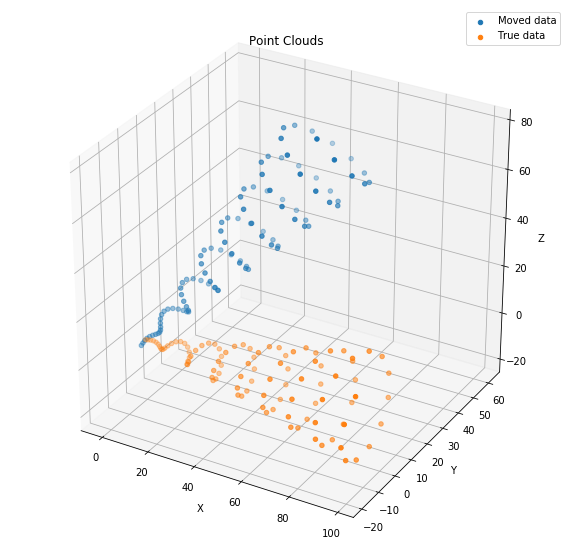

In [3]:
'''Generate data using the sin and cosine functions'''
def generateSpiral(numPoints, angle, shift):
    
    aboutZ = np.array([[cos(angle[2]), -sin(angle[2]), 0], 
                      [sin(angle[2]), cos(angle[2]), 0],
                      [0, 0, 1]])
    aboutY = np.array([[cos(angle[1]), 0, -sin(angle[1])],
                      [0, 1, 0] ,
                      [sin(angle[1]), 0, cos(angle[1])]])
    aboutX = np.array([[1, 0, 0],
                      [0, cos(angle[0]), -sin(angle[0])],
                      [0, sin(angle[0]), cos(angle[0])]])
      
    T = shift
    R = aboutZ.dot(aboutY.dot(aboutX))
    sourceData = np.zeros((3, numPoints))
    sourceData[0, :] = range(0, numPoints)
    sourceData[1, :] = 0.2 * sourceData[0, :] * np.sin(0.5 * sourceData[0, :]) 
    sourceData[2, :] = 0.2 * sourceData[0, :] * np.cos(0.5 * sourceData[0, :]) 
    
    movedData = R.dot(sourceData) + shift
    return sourceData, movedData

'''Assign data to point clouds P and Q''' 
angle = [0, pi/4, pi/4]
shift = np.array([[-2], [0], [-3]])
Q, P = generateSpiral(100, angle, shift)

plotData(P, Q, "Moved data", "True data")
plt.show()

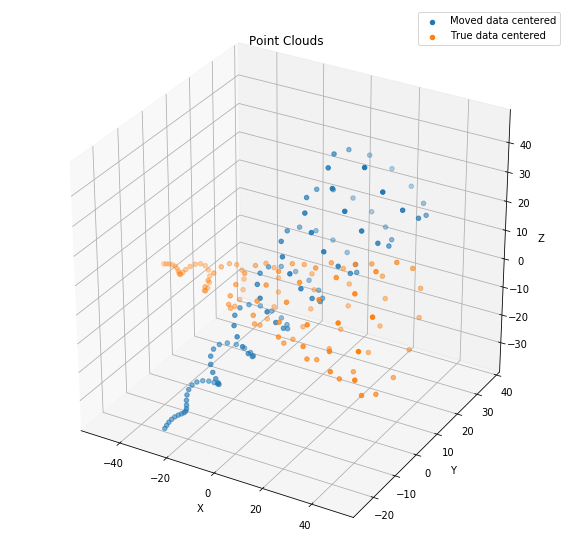

In [4]:
'''Function to center the source data and the moved data'''
def centerData(data, excludeIndices=[]):
    reducedData = np.delete(data, excludeIndices, axis = 1)
    center = np.array([reducedData.mean(axis = 1)]).T
    return center, data - center

centerP, Pcentered = centerData(P)
centerQ, Qcentered = centerData(Q)
plotData(Pcentered, 
         Qcentered,
         'Moved data centered',
         'True data centered')

### KD Tree

In [5]:
class KD_Tree:
    def __init__(self, index, ancestor, mins, maxs):
        self.index = index
        self.ancestor = ancestor
        self.mins = mins
        self.maxs = maxs
        self.direction = None        
        self.pivot = None
        self.left = None
        self.right = None

In [6]:
def split(X, index, method):
    if method == 'maxspread':
        # max spread
        mins = np.min(X[index], axis = 0)
        maxs = np.max(X[index], axis = 0)
        k = np.argmax(maxs - mins)
        middle = (maxs[k] + mins[k]) / 2
        i = index[np.argmin(np.abs(X[index,k] - middle))]
    else:
        # max variance
        k = np.argmax(np.std(X[index], axis = 0))
        i = index[np.argsort(X[index,k])[len(index) // 2]]
    return k, i

In [7]:
def build_kd_tree(X, index = None, ancestor = None, mins = None, maxs = None, leaf_size = 30, method = 'maxspread'):
    if index is None:
        index = np.arange(X.shape[0])
        mins = np.min(X[index], axis = 0)
        maxs = np.max(X[index], axis = 0)
    tree = KD_Tree(index, ancestor, mins, maxs)
    if len(index) > leaf_size:
        k,i = split(X, index, method)
        tree.direction, tree.pivot = k, i
        index = np.array(list(set(index) - {i}))
        index_left = index[np.where(X[index,k] <= X[i,k])[0]]
        maxs_ = maxs.copy()
        maxs_[k] = X[i,k]
        tree.left = build_kd_tree(X, index_left, tree, mins, maxs_, leaf_size, method)
        index_right = index[np.where(X[index,k] > X[i,k])[0]]
        mins_ = mins.copy()
        mins_[k] = X[i,k]        
        tree.right = build_kd_tree(X, index_right, tree, mins_, maxs, leaf_size, method)
    return tree


In [8]:
def search_leaf(x, X, tree):
    if tree.pivot is not None:
        k = tree.direction
        i = tree.pivot
        if x[k] <= X[i,k]:
            return search_leaf(x, X, tree.left)
        else:
            return search_leaf(x, X, tree.right)
    else:
        return tree

In [9]:
def nn_search_kd_tree(x, X, tree):
    node = search_leaf(x, X, tree)
    index = node.index
    nn = None
    if len(index):
        nn = index[np.argmin(np.linalg.norm(X[index] - x, axis = 1))]
        dist = np.linalg.norm(X[nn] - x)
    
    while node.ancestor is not None:
        previous = node
        node = node.ancestor
        if nn is None or np.linalg.norm(X[node.pivot] - x) < dist:
            nn = node.pivot
            dist = np.linalg.norm(X[nn] - x)
        if previous == node.left:
            tree_ = node.right
        else:
            tree_ = node.left
        if tree_ is not None and len(tree_.index):
            explore = False
            if not tree_.pivot:
                explore = True
            else:
                y = np.maximum(tree_.mins, np.minimum(tree_.maxs, x))
                explore = (np.linalg.norm(x - y) < dist)
            if explore:
                ancestor = tree_.ancestor
                tree_.ancestor = None
                nn_ = nn_search_kd_tree(x, X, tree_)
                dist_ = np.linalg.norm(X[nn_] - x)
                if dist_ < dist:
                    nn, dist = nn_, dist_
                tree_.ancestor = ancestor
    return nn

### Finding Correspondences

In [10]:
'''For each point in the  moved data get closest points in the source data using KDTrees'''
def getCorrespondences(P, Q):
    pSize = P.shape[1]
    tree = build_kd_tree(Q.T)
    correspondences = []
    for i in range(pSize):
        pPoint = P[:, i]
        index = nn_search_kd_tree(pPoint.T, Q.T, tree)        
        correspondences.append((i, index))
    return correspondences

'''Connect the obtained corresponding points using grey lines'''
def drawCorrespondences(P, Q, correspondences):
    labelAdded = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        z = [P[2, i], Q[2, j]]
        if not labelAdded:
            plt.plot(x, y, z, color = 'grey', label = 'Correpondences')
            labelAdded = True
        else:
            plt.plot(x, y, z, color = 'grey')
    plt.legend()

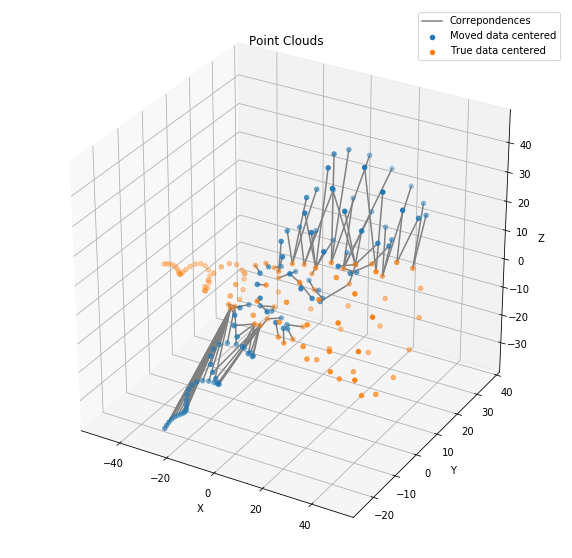

In [11]:
correspondences = getCorrespondences(Pcentered, Qcentered)
plotData(Pcentered, 
         Qcentered,
         'Moved data centered',
         'True data centered')
drawCorrespondences(Pcentered, Qcentered, correspondences)

### Cross Covariance

In [12]:
'''Function to compute the covarianve between the moved data and the source data along the three axes'''
def computeCrosscovariance(P, Q, correspondences, kernel = lambda diff: 1.0):
    cov = np.zeros((3, 3))
    excludeIndices = []
    for i, j in correspondences:
        pPoint = P[:, [i]]
        qPoint = Q[:, [j]]
        weight = kernel(pPoint - qPoint)
        if weight < 0.01: excludeIndices.append(i)
        cov += weight * qPoint.dot(pPoint.T)
    return cov, excludeIndices

In [14]:
def ICP(P, Q, iterations = 10, kernel=lambda diff: 1.0):
    '''Iterations of ICP using SVD'''
    centerQ, Qcentered = centerData(Q)
    normValues = []
    Pvalues = [P.copy()]
    Pcopy = P.copy()
    correspValues = []
    excludeIndices = []
    for i in range(iterations):
        centerP, Pcentered = centerData(Pcopy, excludeIndices)
        correspondences = getCorrespondences(Pcentered, Qcentered)
        correspValues.append(correspondences)
        normValues.append(np.linalg.norm(Pcentered - Qcentered))
        cov, excludeIndices = computeCrosscovariance(Pcentered, Qcentered, correspondences, kernel)
        U, S, VT = np.linalg.svd(cov)
        R = U.dot(VT)  
        t = centerQ - R.dot(centerP)  
        Pcopy = R.dot(Pcopy) + t
        Pvalues.append(Pcopy)
    correspValues.append(correspValues[-1])
    return Pvalues, normValues, correspValues

### Result

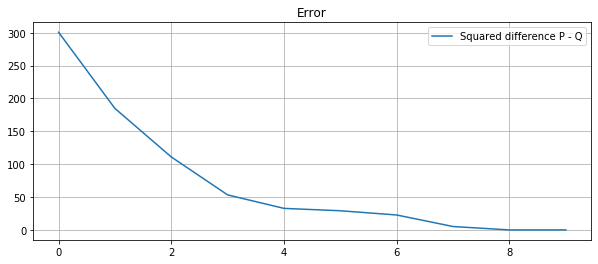

CPU times: user 314 ms, sys: 10.9 ms, total: 325 ms
Wall time: 292 ms


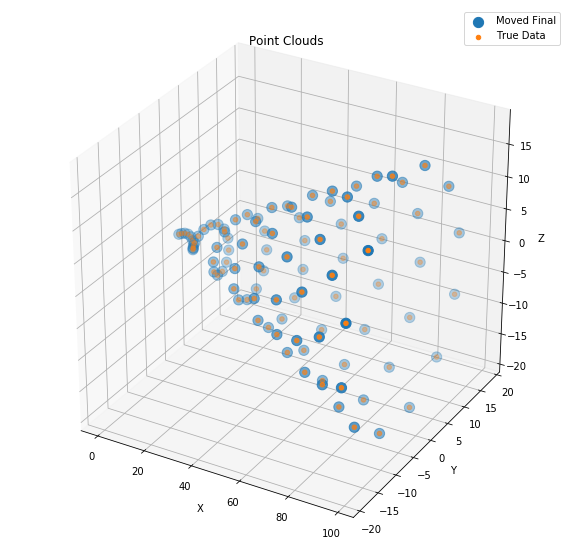

In [15]:
%%time
Pvalues, normValues, correspValues = ICP(P, Q)
plotValues(normValues, "Squared difference P - Q")
plotData(Pvalues[-1], Q, 'Moved Final', 'True Data', markersize1 = 105)